In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip uninstall tensorflow 
#!pip install tensorflow==2.7

In [ ]:
import base64
import os.path
import numpy as np
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.9.2'

In [ ]:
#!pip freeze > requirements.txt

In [ ]:
#!python3 -m  pipreqs.pipreqs .

In [ ]:
print(tf.__version__)

2.9.2


In [ ]:
def base64_2_png():
  os.mkdir("Covid19Data")
  os.makedirs("Covid19Data/Covid")
  os.makedirs("Covid19Data/Normal")

#covid imgs
  for i in range (100):
  # Reading from file
    with open(f"/content/drive/MyDrive/Covid19/Covid Dataset/Covid19_Base64/Covid/COVID-{i+1}.txt", "rb+") as file1:
      # Reading form a file
      # Image Base64 String
      imageData = file1.read()
      print(imageData)
    #imageData = encodedString;
    # Decode base64 String Data
    decodedData = base64.b64decode((imageData))  
    # Write Image from Base64 File
    save_path = '/content/Covid19Data/Covid'
    completeName = os.path.join(save_path, f"COVID-{i+1}"".png")  
    imgFile = open(completeName, 'wb')
    imgFile.write(decodedData)
    imgFile.close()
    
#normal imgs
  for j in range (100):
  # Reading from file
    with open(f"/content/drive/MyDrive/Covid19/Covid Dataset/Covid19_Base64/Normal/Normal-{j+1}.txt", "rb+") as file1:
      # Reading form a file
      # Image Base64 String
      imageData = file1.read()
      print(imageData)
  #imageData = encodedString;
    # Decode base64 String Data
    decodedData = base64.b64decode((imageData))  
    # Write Image from Base64 File
    save_path = '/content/Covid19Data/Normal'
    completeName = os.path.join(save_path, f"Normal-{j+1}"".png")  
    imgFile = open(completeName, 'wb')
    imgFile.write(decodedData)
    imgFile.close()

In [ ]:
base64_2_png()

In [ ]:
y = np.zeros(200)
y[:100] = 0
y[100:200] = 1 # 1 = Covid+ve

In [ ]:
X = np.zeros((200,256,256,3))

#normal first

for i in range(100):
  img = cv2.imread(f"/content/Covid19Data/Normal/Normal-{i+1}.png") #cvt to greyscale by 0 ....Ada path
  img = cv2.resize(img, (256,256))
  X[i] = img.copy()

for i in range(100):
  img = cv2.imread(f"/content/Covid19Data/Covid/COVID-{i+1}.png") #cvt to greyscale by 0....Ada path
  img = cv2.resize(img, (256,256))
  X[i+100] = img.copy() # storing after 100, first 100= normal CXR

X = X/255.0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

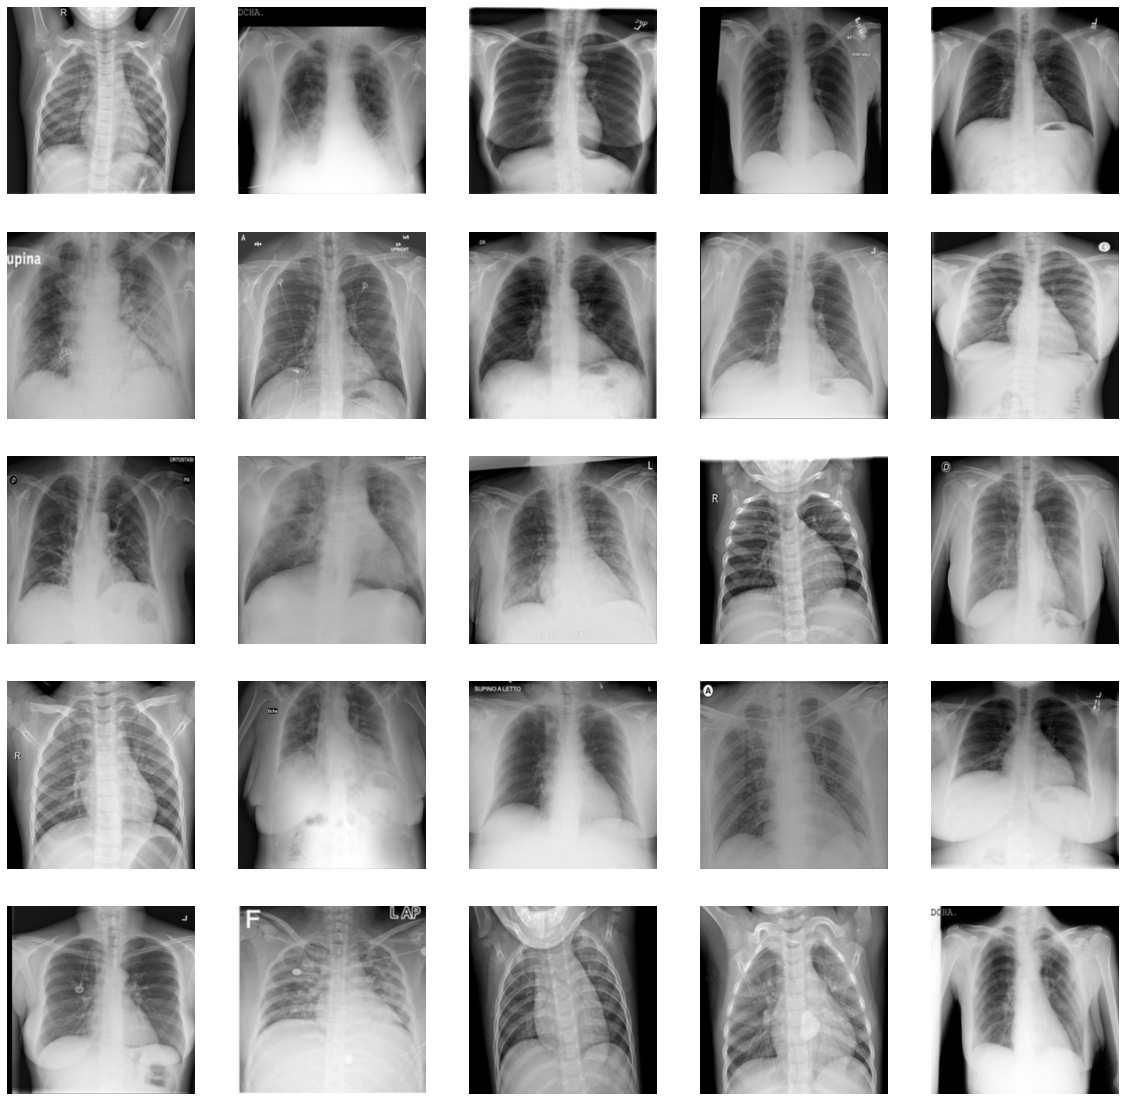

In [ ]:
# plot images
fig, ax = plt.subplots(5,5, figsize=(20,20))

for i,v in enumerate(np.random.choice(len(X_train), 25, replace=False)):
  img = X_train[v,:,:].copy()
  ax[i//5][i%5].imshow(img)
  ax[i//5][i%5].axis('off')

In [ ]:
from tensorflow import keras
from keras import layers

data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(256, 256, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(256, 256, 3))
l = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
l = scale_layer(l)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
l = base_model(l, training=False)
l = keras.layers.GlobalAveragePooling2D()(l)
l = keras.layers.Dropout(0.2)(l)  # Regularize with dropout
outputs = keras.layers.Dense(1)(l)
model = keras.Model(inputs, outputs)

model.summary()

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0      

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

In [ ]:
def fine_tune(model, X_train, y_train, X_test, y_test, epochs = 10,learning_rate = 1e-5):
  base_model.trainable = True
  model.summary()

  model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
  )

  epochs = 10
  model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test))

In [ ]:
fine_tune(model,X_train, y_train, X_test, y_test)

In [ ]:
# Scoring
predictions = (model.predict(X_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
print(classification_report(y_test, predictions))

# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
print('AUC: %.3f' % auc)

In [ ]:
model.save("covidModel.h5")

In [ ]:
!pipreqs . --force
!pipreqs .

# Conversion from KERAS to ONNX

In [ ]:
# let's install the onnx packages from the source
#!pip install --quiet -U onnxruntime
#!pip install --quiet -U git+https://github.com/microsoft/onnxconverter-common
#!pip install --quiet -U git+https://github.com/onnx/keras-onnx

In [ ]:
#import keras2onnx
#print("keras2onnx version is "+keras2onnx.__version__)
# convert to onnx model
#onnx_model = keras2onnx.convert_keras(model, 'covid-onnx', debug_mode=1)
#output_model_path = "./covid-model.onnx"
# and save the model in ONNX format
#keras2onnx.save_model(onnx_model, output_model_path)